In [1]:
import pandas as pd
import sqlalchemy
import sqlite3

print("Pandas version:", pd.__version__)
print("SQLAlchemy version:", sqlalchemy.__version__)
print("SQLite3 version:", sqlite3.version)

Pandas version: 2.2.2
SQLAlchemy version: 2.0.30
SQLite3 version: 2.6.0


C:\Users\lenovo\AppData\Local\Temp\ipykernel_13444\3661269054.py:7: DeprecationWarning: version is deprecated and will be removed in Python 3.14
  print("SQLite3 version:", sqlite3.version)


# Extract Phase
This section loads the e-commerce data from data.csv

In [2]:
# Extract function
def extract_data(file_path):
    df = pd.read_csv(file_path, encoding='latin1')  # 'latin1' handles special characters
    print(f"Extracted {len(df)} records from {file_path}")
    return df

# Run extraction
raw_data = extract_data("data.csv")
raw_data.head()  # Display first 5 rows

Extracted 541909 records from data.csv


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# Transform Phase
This section cleans the data, adds a TotalPrice column, and creates summaries by product and customer.

In [3]:
# First, let’s clean up the data
# Remove rows where CustomerID is missing because we need it for customer analysis
cleaned_data = raw_data.dropna(subset=['CustomerID'])

# Also, filter out negative quantities (like returns) since we want sales only
cleaned_data = cleaned_data[cleaned_data['Quantity'] > 0]

# Check how many rows we have left
print(f"After cleaning, we have {len(cleaned_data)} rows (started with {len(raw_data)})")
cleaned_data.head()

After cleaning, we have 397924 rows (started with 541909)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
# The InvoiceDate column is text, so let’s make it a proper date
cleaned_data['InvoiceDate'] = pd.to_datetime(cleaned_data['InvoiceDate'])

# Quick look to make sure it worked
print("Sample of InvoiceDate after conversion:")
display(cleaned_data[['InvoiceDate']].head())

Sample of InvoiceDate after conversion:


,InvoiceDate
0,2010-12-01 08:26:00
1,2010-12-01 08:26:00
2,2010-12-01 08:26:00
3,2010-12-01 08:26:00
4,2010-12-01 08:26:00


In [5]:
# Let’s calculate the total price for each transaction
cleaned_data['TotalPrice'] = cleaned_data['Quantity'] * cleaned_data['UnitPrice']

# Check a few rows to see the new column
print("Added TotalPrice column:")
display(cleaned_data[['Quantity', 'UnitPrice', 'TotalPrice']].head())

Added TotalPrice column:


,Quantity,UnitPrice,TotalPrice
0,6,2.55,15.30
1,6,3.39,20.34
2,8,2.75,22.00
3,6,3.39,20.34
4,6,3.39,20.34


In [7]:
# Now, let’s see which products sold the most
product_summary = cleaned_data.groupby('Description').sum(numeric_only=True)[['Quantity', 'TotalPrice']]

# Rename Quantity to TotalQuantity to be clear
product_summary = product_summary.rename(columns={'Quantity': 'TotalQuantity'})

# Reset the index so Description isn’t the index
product_summary = product_summary.reset_index()

# Look at the top 5 products by total price
print("Top products by TotalPrice:")
display(product_summary.sort_values('TotalPrice', ascending=False).head())

Top products by TotalPrice:


,Description,TotalQuantity,TotalPrice
2319,"PAPER CRAFT , LITTLE BIRDIE",80995,168469.60
2767,REGENCY CAKESTAND 3 TIER,12412,142592.95
3698,WHITE HANGING HEART T-LIGHT HOLDER,36725,100448.15
1762,JUMBO BAG RED RETROSPOT,46181,85220.78
1992,MEDIUM CERAMIC TOP STORAGE JAR,77916,81416.73


In [8]:
# Let’s figure out customer spending and order counts
customer_summary = cleaned_data.groupby('CustomerID').agg({
    'TotalPrice': 'sum',        # Total spending per customer
    'InvoiceNo': 'nunique'      # Number of unique orders
})

# Rename InvoiceNo to OrderCount
customer_summary = customer_summary.rename(columns={'InvoiceNo': 'OrderCount'})

# Reset index to make CustomerID a column
customer_summary = customer_summary.reset_index()

# Show top 5 customers by spending
print("Top customers by TotalPrice:")
display(customer_summary.sort_values('TotalPrice', ascending=False).head())

Top customers by TotalPrice:


,CustomerID,TotalPrice,OrderCount
1690,14646.0,280206.02,74
4202,18102.0,259657.30,60
3729,17450.0,194550.79,46
3009,16446.0,168472.50,2
1880,14911.0,143825.06,201


# Load Phase
Time to save my cleaned and summarized data into a database!

In [9]:
# Import the database tool
from sqlalchemy import create_engine

# Create a database file
engine = create_engine('sqlite:///ecommerce.db')

# Save my tables
cleaned_data.to_sql('transactions', engine, if_exists='replace', index=False)
product_summary.to_sql('product_sales', engine, if_exists='replace', index=False)
customer_summary.to_sql('customer_sales', engine, if_exists='replace', index=False)

print("Saved everything to ecommerce.db!")

Saved everything to ecommerce.db!


# Quick Analysis
chart to see which products are the best sellers!

In [10]:
# Let’s visualize the top 10 products by sales
import matplotlib.pyplot as plt

In [11]:
# Pick the top 10 products by TotalPrice
top_products = product_summary.sort_values('TotalPrice', ascending=False).head(10)

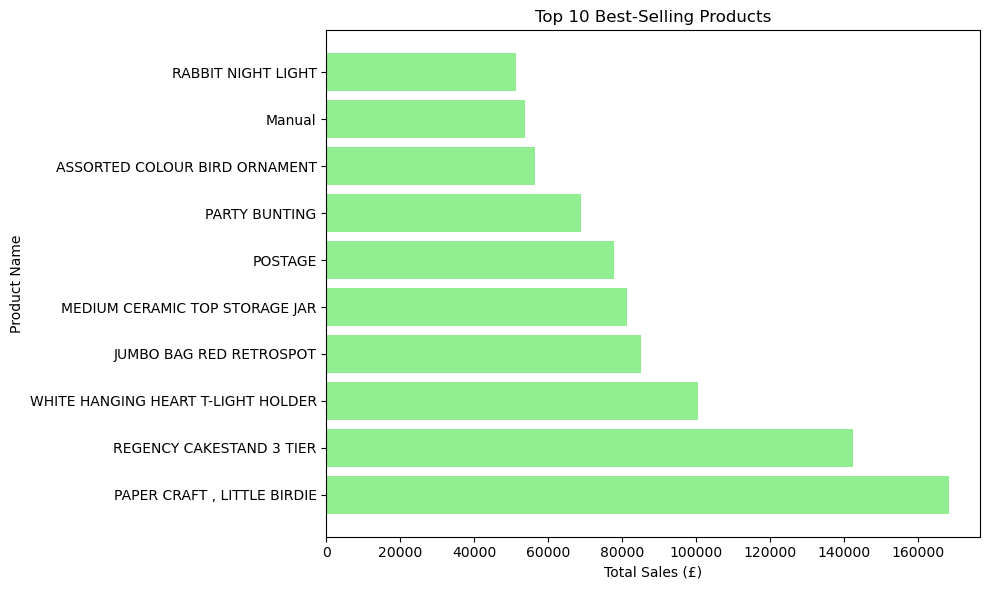

In [13]:
# horizontal bar chart
plt.figure(figsize=(10, 6))  # Bigger size so names fit
plt.barh(top_products['Description'], top_products['TotalPrice'], color='lightgreen')
plt.xlabel('Total Sales (£)')
plt.ylabel('Product Name')
plt.title('Top 10 Best-Selling Products')
plt.tight_layout()  # Avoid cutting off labels

# Show it
plt.show()

In [14]:
# save image
plt.savefig('top_products.png')
print("Chart saved as top_products.png!")

Chart saved as top_products.png!


<Figure size 640x480 with 0 Axes>

In [15]:
# Let’s look at a few rows from the database
import sqlite3

In [16]:
# Connect to the database
conn = sqlite3.connect('ecommerce.db')

In [17]:
# Check the transactions table
test_transactions = pd.read_sql("SELECT * FROM transactions LIMIT 5", conn)
print("Sample from transactions table:")
display(test_transactions)

# Close the connection
conn.close()

Sample from transactions table:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00.000000,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00.000000,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00.000000,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00.000000,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00.000000,3.39,17850.0,United Kingdom,20.34


# Project Summary
Here’s what I did in this e-commerce ETL project:
- **Extract**: Loaded sales data from data.csv (541,909 rows).
- **Transform**: Cleaned it to 397,924 rows (removed missing CustomerIDs and returns), added TotalPrice, and summarized by product and customer.
- **Load**: Saved everything to a SQLite database (ecommerce.db) with three tables: transactions, product_sales, customer_sales.
- **Analysis**: Made a chart of the top 10 products by sales.